In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import RFECV, RFE
import joblib
from copy import deepcopy
import itertools
from sklearn.metrics import r2_score, roc_curve, auc, confusion_matrix
from scipy.signal import savgol_filter, find_peaks
from scipy.interpolate import interp1d
from statannot import add_stat_annotation
from sklearn.decomposition import PCA
from itertools import chain
import forestci as fci
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from scipy.stats import kruskal

# Prepare input data for machine learning

## read copy number table and reformat using dummy variable

In [2]:
df_cn = pd.read_csv('../../cnv_new/msk_isolates/orf_copy_number.for_model.csv', index_col=0)
df_cn = df_cn.loc[:, df_cn.var()!=0] # in case some columns have zero variance
df_cn.head()

,CPAR2_100740,CPAR2_100780,CPAR2_100840,CPAR2_101640,CPAR2_101680,CPAR2_101890,CPAR2_102400,CPAR2_102590,CPAR2_102890,CPAR2_103140,...,CPAR2_807740,CPAR2_807840,CPAR2_807900,CPAR2_807910,CPAR2_808020,CPAR2_808110,CPAR2_808120,CPAR2_808310,CPAR2_808320,CPAR2_809000
GenomeID,,,,,,,,,,,,,,,,,,,,,
1,2,2,2,2,2,1,2,2,2,0,...,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,1,2,2,2,0,...,2,2,2,2,2,2,2,2,2,2
5,2,2,2,2,2,1,2,2,2,0,...,2,2,2,2,2,2,2,2,2,2
17,2,2,2,2,2,1,2,2,2,0,...,2,2,2,2,2,2,2,2,2,2
18,2,2,2,2,2,1,2,2,2,0,...,2,2,2,2,2,2,2,2,2,2


## mannually turn 1666 CNV3 (CPAR2_805410) from 1 to 0

In [3]:
df_cn.loc[1666,'CPAR2_805410']

1

In [4]:
df_cn.loc[1666,'CPAR2_805410'] = 0

## read genomic variants table and reformat using dummy variable

In [5]:
df_var = pd.read_csv('../../MSK_HCT_isolates/cohort.filtered.gt_numeric.for_model.csv', index_col=0)
df_var = df_var.replace({0:'HomRef',1:'Het',2:'HomAlt'})
df_var = pd.get_dummies(df_var, drop_first=False, prefix_sep='$')
df_var = df_var[[col for col in df_var.columns if 'HomRef' not in col]]
df_var = df_var.loc[:, df_var.var()!=0] # in case some columns have zero variance
df_var.head()

,Contig005504_C_parapsilosis_CDC317:470:SNP$HomAlt,Contig005504_C_parapsilosis_CDC317:496:SNP$HomAlt,Contig005504_C_parapsilosis_CDC317:547:SNP$HomAlt,Contig005504_C_parapsilosis_CDC317:624:SNP$Het,Contig005504_C_parapsilosis_CDC317:1287:SNP$Het,Contig005504_C_parapsilosis_CDC317:1291:SNP$HomAlt,Contig005504_C_parapsilosis_CDC317:4654:SNP$Het,Contig005504_C_parapsilosis_CDC317:5516:SNP$Het,Contig005504_C_parapsilosis_CDC317:5516:SNP$HomAlt,Contig005504_C_parapsilosis_CDC317:10633:SNP$Het,...,mito_C_parapsilosis_CDC317:26318:SNP$HomAlt,mito_C_parapsilosis_CDC317:26551:INDEL$HomAlt,mito_C_parapsilosis_CDC317:27825:SNP$HomAlt,mito_C_parapsilosis_CDC317:28000:SNP$HomAlt,mito_C_parapsilosis_CDC317:28641:SNP$HomAlt,mito_C_parapsilosis_CDC317:28642:SNP$HomAlt,mito_C_parapsilosis_CDC317:29232:SNP$HomAlt,mito_C_parapsilosis_CDC317:29635:SNP$HomAlt,mito_C_parapsilosis_CDC317:30051:SNP$HomAlt,mito_C_parapsilosis_CDC317:31150:INDEL$HomAlt
1004,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1015,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1082,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1090,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1119,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## merge two tables

In [6]:
# merge
df_X = pd.merge(df_cn, df_var, left_index=True, right_index=True, how='inner')
assert len(df_X) == 118
assert df_X.isnull().values.any() == False # make sure no NaN in the dataframe
df_X.head()

,CPAR2_100740,CPAR2_100780,CPAR2_100840,CPAR2_101640,CPAR2_101680,CPAR2_101890,CPAR2_102400,CPAR2_102590,CPAR2_102890,CPAR2_103140,...,mito_C_parapsilosis_CDC317:26318:SNP$HomAlt,mito_C_parapsilosis_CDC317:26551:INDEL$HomAlt,mito_C_parapsilosis_CDC317:27825:SNP$HomAlt,mito_C_parapsilosis_CDC317:28000:SNP$HomAlt,mito_C_parapsilosis_CDC317:28641:SNP$HomAlt,mito_C_parapsilosis_CDC317:28642:SNP$HomAlt,mito_C_parapsilosis_CDC317:29232:SNP$HomAlt,mito_C_parapsilosis_CDC317:29635:SNP$HomAlt,mito_C_parapsilosis_CDC317:30051:SNP$HomAlt,mito_C_parapsilosis_CDC317:31150:INDEL$HomAlt
1,2,2,2,2,2,1,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,2,2,2,1,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0
5,2,2,2,2,2,1,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0
17,2,2,2,2,2,1,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0
18,2,2,2,2,2,1,2,2,2,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
df_X_T = deepcopy(df_X.T)
df_X_T['Concat'] = df_X_T.astype(str).apply(''.join, axis=1)
df_X_T = pd.merge(df_X_T, df_X_T.Concat.value_counts().apply(lambda x: 1 if x>1 else np.nan).cumsum().rename('GroupID').to_frame().fillna(0).astype(int), left_on='Concat', right_index=True).sort_index()
duplicate_dict = {'Group_%d'%(groupid):list(df_X_T[df_X_T.GroupID==groupid].index) for groupid in set(df_X_T.GroupID) if groupid >0}
joblib.dump(duplicate_dict, 'feature_groups_all.joblib')

['feature_groups_all.joblib']

## read HR score (make sure df_X and df_Y have rows matched)

In [7]:
df_Y = pd.read_csv('../../quantification/hr_score_msk_strains.csv', index_col=0).loc[df_X.index,['Score','ASV','Is_HR_NMF']]
df_Y = df_Y.loc[df_X.index]
df_Y = df_Y.rename({'Is_HR_NMF':'Is_HR'}, axis=1)
df_Y.loc[df_Y.ASV=='ASV_1','ASV'] = 0
df_Y.loc[df_Y.ASV=='ASV_3','ASV'] = 1
df_Y.head()

,Score,ASV,Is_HR
1,0.813608,1,True
2,0.672028,1,True
5,0.634746,1,True
17,0.438212,1,True
18,0.404098,1,True


## feature selection by LASSO 

In [8]:
cnv_features = list(df_cn.columns)
snv_features = list(df_var.columns)

reg_cnv = LassoCV(
    cv=5, 
    random_state=0,
    n_alphas=1000,
    max_iter=100000,
    verbose=0,
    n_jobs=-1,
).fit(df_X[cnv_features], np.ravel(df_Y[['Score']].values))
print('best alpha for cnv= %2.4f'%(reg_cnv.alpha_))
df_reg_cnv = pd.DataFrame(reg_cnv.coef_, index=df_X[cnv_features].columns, columns=['Coef'])

# regardless of the result
# add CPAR2_104610 and CPAR2_601050
df_reg_cnv.loc[['CPAR2_104610','CPAR2_601050'], 'Coef'] = 1.0

df_reg_cnv = df_reg_cnv[df_reg_cnv.Coef != 0]

reg_snv = LassoCV(
    cv=5, 
    random_state=0,
    n_alphas=1000,
    max_iter=100000,
    verbose=0,
    n_jobs=-1,
).fit(df_X[snv_features], np.ravel(df_Y[['Score']].values))
print('best alpha for snv= %2.4f'%(reg_snv.alpha_))
df_reg_snv = pd.DataFrame(reg_snv.coef_, index=df_X[snv_features].columns, columns=['Coef'])
df_reg_snv = df_reg_snv[df_reg_snv.Coef != 0]

# get coefficients
df_X_cnv_snv = deepcopy(df_X[list(df_reg_cnv.index)+list(df_reg_snv.index)])
df_X_snv = deepcopy(df_X[list(df_reg_snv.index)])
df_X_cnv = deepcopy(df_X[list(df_reg_cnv.index)])
print('number of features for cnv+snv model = %d'%(len(df_X_cnv_snv.columns)))
print('number of features for snv only model = %d'%(len(df_X_snv.columns)))
print('number of features for cnv only model = %d'%(len(df_X_cnv.columns)))

best alpha for cnv= 0.0193
best alpha for snv= 0.0157
number of features for cnv+snv model = 18
number of features for snv only model = 14
number of features for cnv only model = 4


In [9]:
print(df_X_cnv_snv.columns)

Index(['CPAR2_104600', 'CPAR2_104610', 'CPAR2_601050', 'CPAR2_805410',
       'Contig005569_C_parapsilosis_CDC317:110365:SNP$HomAlt',
       'Contig005569_C_parapsilosis_CDC317:361686:SNP$HomAlt',
       'Contig005569_C_parapsilosis_CDC317:362224:SNP$Het',
       'Contig005807_C_parapsilosis_CDC317:1171160:SNP$HomAlt',
       'Contig005807_C_parapsilosis_CDC317:1213170:INDEL$HomAlt',
       'Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het',
       'Contig005809_C_parapsilosis_CDC317:1476130:SNP$HomAlt',
       'Contig005809_C_parapsilosis_CDC317:1574350:SNP$HomAlt',
       'Contig005809_C_parapsilosis_CDC317:1836285:SNP$HomAlt',
       'Contig005809_C_parapsilosis_CDC317:2251778:SNP$HomAlt',
       'Contig006372_C_parapsilosis_CDC317:863364:SNP$HomAlt',
       'Contig006372_C_parapsilosis_CDC317:863822:INDEL$HomAlt',
       'Contig006372_C_parapsilosis_CDC317:864071:SNP$HomAlt',
       'Contig006372_C_parapsilosis_CDC317:864439:INDEL$HomAlt'],
      dtype='object')


## combine features with exactly the same values

In [10]:
# snv + cnv
df_X_cnv_snv_T = deepcopy(df_X_cnv_snv.T)
df_X_cnv_snv_T['Concat'] = df_X_cnv_snv_T.astype(str).apply(''.join, axis=1)
df_X_cnv_snv_T = pd.merge(df_X_cnv_snv_T, df_X_cnv_snv_T.Concat.value_counts().apply(lambda x: 1 if x>1 else np.nan).cumsum().rename('GroupID').to_frame().fillna(0).astype(int), left_on='Concat', right_index=True).sort_index()
duplicate_dict = {'Group_%d'%(groupid):list(df_X_cnv_snv_T[df_X_cnv_snv_T.GroupID==groupid].index) for groupid in set(df_X_cnv_snv_T.GroupID) if groupid >0}
joblib.dump(duplicate_dict, 'feature_groups_lasso_cnv_snv.joblib')
df_X_cnv_snv_T = df_X_cnv_snv_T.reset_index().rename({'index':'Feature'}, axis=1)
df_X_cnv_snv_T['Feature'] = [feature if groupid==0 else 'Group_%d'%(groupid) for groupid,feature in zip(df_X_cnv_snv_T.GroupID,df_X_cnv_snv_T.Feature)]
df_X_cnv_snv_T = df_X_cnv_snv_T.drop(['Concat','GroupID'], axis=1).drop_duplicates().set_index('Feature')
df_X_cnv_snv = df_X_cnv_snv_T.T.astype(int)
print('# features in cnv+snv model = %d'%(len(df_X_cnv_snv.columns)))

# snv only
df_X_snv_T = deepcopy(df_X_snv.T)
df_X_snv_T['Concat'] = df_X_snv_T.astype(str).apply(''.join, axis=1)
df_X_snv_T = pd.merge(df_X_snv_T, df_X_snv_T.Concat.value_counts().apply(lambda x: 1 if x>1 else np.nan).cumsum().rename('GroupID').to_frame().fillna(0).astype(int), left_on='Concat', right_index=True).sort_index()
duplicate_dict = {'Group_%d'%(groupid):list(df_X_snv_T[df_X_snv_T.GroupID==groupid].index) for groupid in set(df_X_snv_T.GroupID) if groupid >0}
joblib.dump(duplicate_dict, 'feature_groups_lasso_snv_only.joblib')
df_X_snv_T = df_X_snv_T.reset_index().rename({'index':'Feature'}, axis=1)
df_X_snv_T['Feature'] = [feature if groupid==0 else 'Group_%d'%(groupid) for groupid,feature in zip(df_X_snv_T.GroupID,df_X_snv_T.Feature)]
df_X_snv_T = df_X_snv_T.drop(['Concat','GroupID'], axis=1).drop_duplicates().set_index('Feature')
df_X_snv = df_X_snv_T.T.astype(int)
print('# features in snv only model = %d'%(len(df_X_snv.columns)))

# cnv only
df_X_cnv_T = deepcopy(df_X_cnv.T)
df_X_cnv_T['Concat'] = df_X_cnv_T.astype(str).apply(''.join, axis=1)
df_X_cnv_T = pd.merge(df_X_cnv_T, df_X_cnv_T.Concat.value_counts().apply(lambda x: 1 if x>1 else np.nan).cumsum().rename('GroupID').to_frame().fillna(0).astype(int), left_on='Concat', right_index=True).sort_index()
duplicate_dict = {'Group_%d'%(groupid):list(df_X_cnv_T[df_X_cnv_T.GroupID==groupid].index) for groupid in set(df_X_cnv_T.GroupID) if groupid >0}
joblib.dump(duplicate_dict, 'feature_groups_lasso_cnv_only.joblib')
df_X_cnv_T = df_X_cnv_T.reset_index().rename({'index':'Feature'}, axis=1)
df_X_cnv_T['Feature'] = [feature if groupid==0 else 'Group_%d'%(groupid) for groupid,feature in zip(df_X_cnv_T.GroupID,df_X_cnv_T.Feature)]
df_X_cnv_T = df_X_cnv_T.drop(['Concat','GroupID'], axis=1).drop_duplicates().set_index('Feature')
df_X_cnv = df_X_cnv_T.T.astype(int)
print('# features in cnv only model = %d'%(len(df_X_cnv.columns)))

# features in cnv+snv model = 14
# features in snv only model = 10
# features in cnv only model = 4


In [11]:
df_X_cnv_snv.to_csv('df_X_cnv_snv.csv')
df_X_snv.to_csv('df_X_snv.csv')
df_X_cnv.to_csv('df_X_cnv.csv')

## read sample weights

In [12]:
df_weight = pd.read_csv('../../InStrain/strain_clusters.csv', index_col=0)
df_weight = df_weight.loc[df_X.index]
df_weight.head()

,ClusterName,Weight
1,0,0.000891
2,0,0.000891
5,0,0.000891
17,0,0.000891
18,0,0.000891


# Run PCA on SNVs/InDels

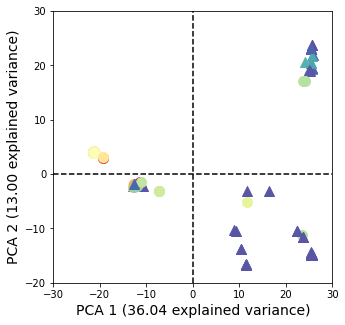

In [13]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Spectral_r)
df_Y['Color'] = [matplotlib.colors.rgb2hex(mapper.to_rgba(v)) for v in df_Y.Score]

n = len(df_var.columns)
strains = list(df_var.index)
variants = list(df_var.columns)

# run pca
pca = PCA(n_components=2)
pca.fit(df_var)

# loadings
xvector = pca.components_[0]
yvector = pca.components_[1]

# scores
xs = pca.transform(df_var)[:,0]
ys = pca.transform(df_var)[:,1]

fig, ax = plt.subplots(figsize=(5,5))
for i,s in enumerate(strains):
    if df_Y.loc[s,'Score']>=0.22:
        ax.scatter(xs[i], ys[i], color=df_Y.loc[s,'Color'], s=100, marker='o')
    else:
        ax.scatter(xs[i], ys[i], color=df_Y.loc[s,'Color'], s=100, marker='^')

_ = ax.set_xlabel('PCA 1 (%2.2f explained variance)'%(pca.explained_variance_ratio_[0]*100), fontsize=14)
_ = ax.set_ylabel('PCA 2 (%2.2f explained variance)'%(pca.explained_variance_ratio_[1]*100), fontsize=14)
_ = ax.set_xlim([-30,30])
_ = ax.set_ylim([-20,30])
_ = ax.plot([-30,30],[0,0],'k--')
_ = ax.plot([0,0],[-20,30],'k--')

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('pca_orf_snv.svg', dpi=600)

# Run PCA on copy number variation

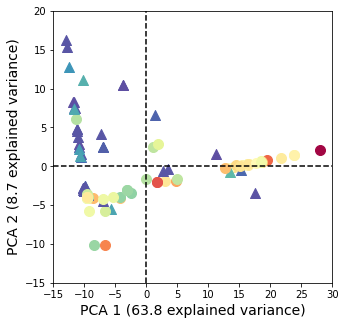

In [14]:
n = len(df_cn.columns)
strains = list(df_cn.index)
variants = list(df_cn.columns)

# run pca
pca = PCA(n_components=2)
pca.fit(df_cn)

# loadings
xvector = pca.components_[0]
yvector = pca.components_[1]

# scores
xs = pca.transform(df_cn)[:,0]
ys = pca.transform(df_cn)[:,1]

fig, ax = plt.subplots(figsize=(5,5))
for i,s in enumerate(strains):
    if df_Y.loc[s,'Score']>=0.22:
        ax.scatter(xs[i], ys[i], color=df_Y.loc[s,'Color'], s=100, marker='o')
    else:
        ax.scatter(xs[i], ys[i], color=df_Y.loc[s,'Color'], s=100, marker='^')

_ = ax.set_xlabel('PCA 1 (%2.1f explained variance)'%(pca.explained_variance_ratio_[0]*100), fontsize=14)
_ = ax.set_ylabel('PCA 2 (%2.1f explained variance)'%(pca.explained_variance_ratio_[1]*100), fontsize=14)
_ = ax.set_xlim([-15,30])
_ = ax.set_ylim([-15,20])
_ = ax.plot([-15,30],[0,0],'k--')
_ = ax.plot([0,0],[-15,20],'k--')

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('pca_orf_cnv.svg', dpi=600)

# Model assessment using cross validation

## using cnv + snv and as predictors

In [15]:
X = df_X_cnv_snv.values
y = np.ravel(df_Y.loc[df_X_cnv_snv.index,['Score']].values)
y_binary = np.ravel(df_Y.loc[df_X_cnv_snv.index,['Is_HR']].values)
W = df_weight.loc[df_X_cnv_snv.index,'Weight'].values
param_grid = {
    'max_features':['auto','sqrt','log2',0.16,0.32,0.64,0.81],
    'max_depth':[2,4,8,16,32,64,128],
    'min_samples_split':[2,4,8,16],
    'min_samples_leaf':[1,2,4]
}

best_model_set = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y_binary):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    W_train, W_test = W[train_index], W[test_index]
    
    # do internal cross validation to optimize hyperparameters
    rf = RandomForestRegressor(n_estimators=1000,random_state=42)
    CV = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
    CV.fit(X_train, y_train, sample_weight=W_train)
    best_model = CV.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    best_model_set.append([best_model, train_index, X_train, y_train, y_train_pred, test_index, X_test, y_test, y_test_pred])

joblib.dump(best_model_set, "model_assessment_crossval_cnv_snv.joblib")

['model_assessment_crossval_cnv_snv.joblib']

## using cnv alone as predictors

In [16]:
X = df_X_cnv.values
y = np.ravel(df_Y.loc[df_X_cnv.index,['Score']].values)
y_binary = np.ravel(df_Y.loc[df_X_cnv.index,['Is_HR']].values)
W = df_weight.loc[df_X_cnv.index,'Weight'].values
param_grid = {
    'max_features':['auto','sqrt','log2',0.16,0.32,0.64,0.81],
    'max_depth':[2,4,8,16,32,64,128],
    'min_samples_split':[2,4,8,16],
    'min_samples_leaf':[1,2,4]
}

best_model_set = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y_binary):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    W_train, W_test = W[train_index], W[test_index]
    
    # do internal cross validation to optimize hyperparameters
    rf = RandomForestRegressor(n_estimators=1000,random_state=42)
    CV = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
    CV.fit(X_train, y_train, sample_weight=W_train)
    best_model = CV.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    best_model_set.append([best_model, train_index, X_train, y_train, y_train_pred, test_index, X_test, y_test, y_test_pred])

joblib.dump(best_model_set, "model_assessment_crossval_cnv_alone.joblib")

['model_assessment_crossval_cnv_alone.joblib']

## using snv alone as predictors

In [17]:
X = df_X_snv.values
y = np.ravel(df_Y.loc[df_X_snv.index,['Score']].values)
y_binary = np.ravel(df_Y.loc[df_X_snv.index,['Is_HR']].values)
W = df_weight.loc[df_X_snv.index,'Weight'].values
param_grid = {
    'max_features':['auto','sqrt','log2',0.16,0.32,0.64,0.81],
    'max_depth':[2,4,8,16,32,64,128],
    'min_samples_split':[2,4,8,16],
    'min_samples_leaf':[1,2,4]
}

best_model_set = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y_binary):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    W_train, W_test = W[train_index], W[test_index]
    
    # do internal cross validation to optimize hyperparameters
    rf = RandomForestRegressor(n_estimators=1000,random_state=42)
    CV = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
    CV.fit(X_train, y_train, sample_weight=W_train)
    best_model = CV.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    best_model_set.append([best_model, train_index, X_train, y_train, y_train_pred, test_index, X_test, y_test, y_test_pred])

joblib.dump(best_model_set, "model_assessment_crossval_snv_only.joblib")

['model_assessment_crossval_snv_only.joblib']

## using ASVs as predictors

In [18]:
X = list(df_Y.loc[df_X_cnv_snv.index, 'ASV'].values)
y = np.ravel(df_Y.loc[df_X_cnv_snv.index, ['Score']].values)
y_binary = np.ravel(df_Y.loc[df_X_cnv_snv.index,['Is_HR']].values)
W = df_weight.loc[df_X_cnv_snv.index,'Weight'].values
param_grid = {
    'max_features':['auto','sqrt','log2',0.16,0.32,0.64,0.81],
    'max_depth':[2,4,8,16,32,64,128],
    'min_samples_split':[2,4,8,16],
    'min_samples_leaf':[1,2,4]
}

best_model_set = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y_binary):
    X_train, X_test = np.array([X[i] for i in train_index]).reshape(-1,1), np.array([X[j] for j in test_index]).reshape(-1,1)
    y_train, y_test = [y[i] for i in train_index], [y[j] for j in test_index]
    W_train, W_test = [W[i] for i in train_index], [W[j] for j in test_index]
   
    # do internal cross validation to optimize hyperparameters
    rf = RandomForestRegressor(n_estimators=1000,random_state=42)
    CV = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
    CV.fit(X_train, y_train, sample_weight=W_train)
    best_model = CV.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    best_model_set.append([best_model, train_index, X_train, y_train, y_train_pred, test_index, X_test, y_test, y_test_pred])

joblib.dump(best_model_set, "model_assessment_crossval_asv.joblib")

['model_assessment_crossval_asv.joblib']

## using phylogenetic signals as predictors

In [20]:
df_phylo = pd.read_csv('../../build_tree/MSK/RAxML/variance_covariance_matrix.csv', index_col=0)
df_phylo = df_phylo.drop(2160, axis=0).drop('2160', axis=1)
pca = PCA()
pca.fit(df_phylo)
df_pca_score = pd.DataFrame(pca.transform(df_phylo), index=df_phylo.index)

X = df_pca_score.loc[df_X_cnv_snv.index,:].values
y = np.ravel(df_Y.loc[df_X_cnv_snv.index, ['Score']].values)
y_binary = np.ravel(df_Y.loc[df_X_cnv_snv.index,['Is_HR']].values)
W = df_weight.loc[df_X_cnv_snv.index,'Weight'].values
param_grid = {
    'max_features':['auto','sqrt','log2',0.16,0.32,0.64,0.81],
    'max_depth':[2,4,8,16,32,64,128],
    'min_samples_split':[2,4,8,16],
    'min_samples_leaf':[1,2,4]
}

best_model_set = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y_binary):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    W_train, W_test = W[train_index], W[test_index]
    
    # do internal cross validation to optimize hyperparameters
    rf = RandomForestRegressor(n_estimators=1000,random_state=42)
    CV = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
    CV.fit(X_train, y_train, sample_weight=W_train)
    best_model = CV.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    best_model_set.append([best_model, train_index, X_train, y_train, y_train_pred, test_index, X_test, y_test, y_test_pred])

joblib.dump(best_model_set, "model_assessment_crossval_phylo_pca.joblib")

['model_assessment_crossval_phylo_pca.joblib']

## Summarize the predictions for the CNV + SNV model

In [21]:
best_model_set = joblib.load('model_assessment_crossval_cnv_snv.joblib')

lines = []
all_genomeIDs = list(df_X.index)
for k in np.arange(len(best_model_set)):
    test_index = best_model_set[k][5]
    y_test = best_model_set[k][7]
    y_test_pred = best_model_set[k][8]
    
    # estimate variance
    X_train = best_model_set[k][2]
    X_test = best_model_set[k][6]
    model = best_model_set[k][0]
    variance = fci.random_forest_error(model, X_train, X_test)
    for ti, y1, y2, var in zip(test_index, y_test, y_test_pred, variance):
        y1_label = df_Y.loc[all_genomeIDs[ti], 'Is_HR']
        y2_label = y2>=0.22
        if y1_label != y2_label:
            if y1_label == 0 and y2_label == 1:
                lines.append([k+1, all_genomeIDs[ti], y1, y2, np.sqrt(var), y1_label, y2_label, 'FP'])
            else:
                lines.append([k+1, all_genomeIDs[ti], y1, y2, np.sqrt(var), y1_label, y2_label, 'FN'])
        else:
            if y1_label == 0 and y2_label == 0:
                lines.append([k+1, all_genomeIDs[ti], y1, y2, np.sqrt(var), y1_label, y2_label, 'TN'])
            else:
                lines.append([k+1, all_genomeIDs[ti], y1, y2, np.sqrt(var), y1_label, y2_label, 'TP'])
                              
df_summary = pd.DataFrame(lines, columns=['Fold','GenomeID','HR_obs','HR_pred','Std','HR_label_obs','HR_label_pred','Outcome'])
df_summary.to_csv('Prediction_summary_cnv_snv_model.csv', index=False)
df_summary.head()

,Fold,GenomeID,HR_obs,HR_pred,Std,HR_label_obs,HR_label_pred,Outcome
0,1,5,0.634746,0.576085,0.040610,True,True,TP
1,1,18,0.404098,0.539784,0.039283,True,True,TP
2,1,49,0.476159,0.576085,0.040610,True,True,TP
3,1,250,0.013358,0.049154,0.038788,False,False,TN
4,1,264,0.471364,0.577341,0.041036,True,True,TP


In [22]:
df_summary[df_summary.Outcome.isin(['FP','FN'])]

,Fold,GenomeID,HR_obs,HR_pred,Std,HR_label_obs,HR_label_pred,Outcome
19,1,2384,0.400334,0.184418,0.038636,True,False,FN
31,2,813,0.043253,0.418083,0.053477,False,True,FP
40,2,2191,0.318113,0.027994,0.039448,True,False,FN
55,3,809,0.317588,0.204311,0.073510,True,False,FN
62,3,1398,0.152333,0.506859,0.064625,False,True,FP
68,3,2159,0.012660,0.512462,0.067543,False,True,FP
105,5,800,0.186613,0.320397,0.098401,False,True,FP


## Show cross validation scatterplot

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw =

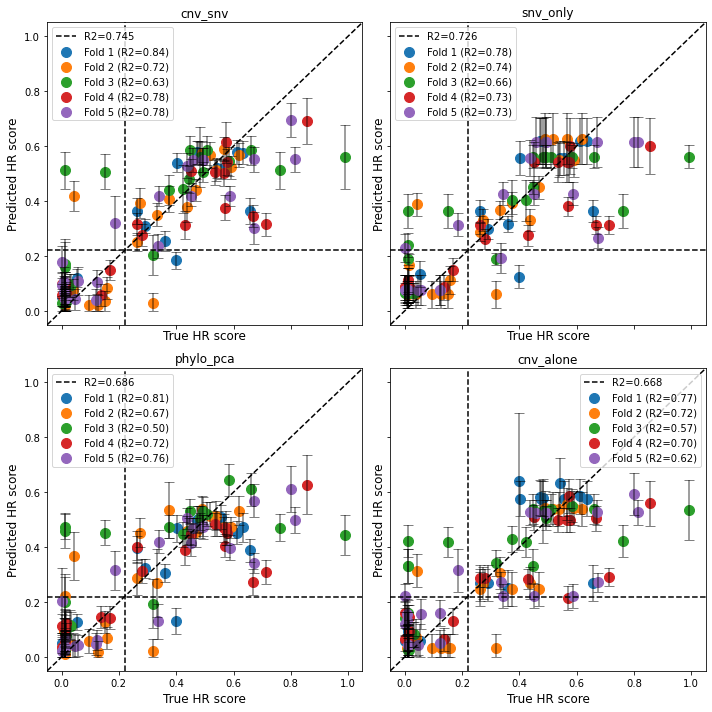

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True, sharey=True)

for i,key in enumerate(['cnv_snv','snv_only','phylo_pca','cnv_alone']):
    rowidx = int(i/2)
    colidx = i%2
    
    best_model_set = joblib.load('model_assessment_crossval_%s.joblib'%(key))
    y_test_all = []
    y_pred_all = []
    for k in np.arange(len(best_model_set)):
        y_test = best_model_set[k][7]
        y_test_pred = best_model_set[k][8]
        X_train = best_model_set[k][2]
        X_test = best_model_set[k][6]
        model = best_model_set[k][0]
        variance = fci.random_forest_error(model, X_train, X_test)
        std = [np.sqrt(v) for v in variance]
        std_up = [std if mean+std<=1 else 1-mean for std, mean in zip(std, y_test_pred)]
        std_down = [std if mean-std>=0 else mean for std, mean in zip(std, y_test_pred)]
        
        r2 = r2_score(y_pred=y_test_pred, y_true=y_test)
        _ = ax[rowidx,colidx].scatter(y_test, y_test_pred, label='Fold %d (R2=%0.2f)'%(k+1,r2), s=100, marker='o')
        _ = ax[rowidx,colidx].errorbar(y_test, y_test_pred, yerr=[std_down,std_up], capsize=5, fmt='none', color='k', alpha=0.5)
        
        y_test_all.extend(y_test)
        y_pred_all.extend(y_test_pred)
    r2_all = r2_score(y_pred=y_pred_all, y_true=y_test_all)
    _ = ax[rowidx,colidx].plot([-0.05,1.05], [-0.05,1.05], 'k--', label='R2=%0.3f'%(r2_all))
    _ = ax[rowidx,colidx].plot([-0.05,1.05], [0.22,0.22], 'k--')
    _ = ax[rowidx,colidx].plot([0.22,0.22], [-0.05,1.05], 'k--')
    _ = ax[rowidx,colidx].legend()
    _ = ax[rowidx,colidx].set_xlim([-0.05,1.05])
    _ = ax[rowidx,colidx].set_ylim([-0.05,1.05])
    _ = ax[rowidx,colidx].set_xlabel('True HR score', fontsize=12)
    _ = ax[rowidx,colidx].set_ylabel('Predicted HR score', fontsize=12)
    _ = ax[rowidx,colidx].set_title(key)
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("model_comparison_r2.svg")

# Build the final model

## cnv + snv

In [24]:
best_model_set = joblib.load('model_assessment_crossval_cnv_snv.joblib')
max_features_union = []
max_depth_union = []
min_samples_split_union = []
min_samples_leaf_union = []

for curr_set in best_model_set:
    max_features_union.append(curr_set[0].max_features)
    max_depth_union.append(curr_set[0].max_depth)
    min_samples_split_union.append(curr_set[0].min_samples_split)
    min_samples_leaf_union.append(curr_set[0].min_samples_leaf)

print('max features = ', set(max_features_union))
print('max depth = ', set(max_depth_union))
print('min samples split = ', set(min_samples_split_union))
print('min samples leaf = ', set(min_samples_leaf_union)) 

max features =  {0.16, 0.32, 'auto'}
max depth =  {8, 4}
min samples split =  {8, 2, 4}
min samples leaf =  {1}


In [25]:
param_grid = {
    'max_features':['sqrt',0.16,'auto'],
    'max_depth':[8,4],
    'min_samples_split':[8,2,4],
    'min_samples_leaf':[1]
}

current_features = list(df_X_cnv_snv.columns)
n_features = len(current_features)
df_X2 = deepcopy(df_X_cnv_snv)
y = np.ravel(df_Y[['Score']].values)
W = np.ravel(df_weight[['Weight']].values)

output = []
ranked_features = []
while n_features>0:
    rf = RandomForestRegressor(n_estimators=1000,random_state=42)
    CV = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
    CV.fit(df_X2.values, y, sample_weight=W)
    best_model = CV.best_estimator_
    
    output.append([n_features, CV.best_score_])
    print(n_features, CV.best_score_)
    
    n_features -= 1
    feature_to_remove = current_features[list(best_model.feature_importances_).index(np.min(best_model.feature_importances_))]
    current_features = [f for f in current_features if f!=feature_to_remove]
    df_X2 = df_X2[current_features]
    ranked_features.append(feature_to_remove)
ranked_features = ranked_features[::-1]

df_rfe = pd.DataFrame(output, columns=['n_features','best_score'])

14 0.7187716322611513
13 0.7177502042804512
12 0.7161011826587118
11 0.7145198706094993
10 0.7121905873970468
9 0.7053045138967908
8 0.6973012489772713
7 0.7023171093542764
6 0.7127917033952413
5 0.6768986770464124
4 0.629827289719689
3 0.6128720732230958
2 0.46694883470911125
1 -0.009292041410382024


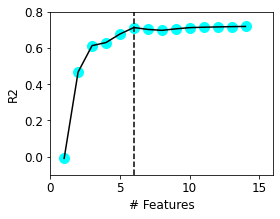

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))

_ = ax.plot(df_rfe.n_features, df_rfe.best_score, 'k-') 
_ = ax.scatter(df_rfe.n_features, df_rfe.best_score, s=100, color='cyan')
_ = ax.tick_params(axis='both', labelsize=12)
_ = ax.set_xlabel('# Features', fontsize=12)
_ = ax.set_ylabel('R2', fontsize=12)
_ = ax.set_ylim([-0.1,0.8])
_ = ax.set_xlim([0,16])
_ = ax.plot([6,6],[-0.1,0.8], 'k--')
   
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("rfe_plot_best_score_cnv_snv.svg", format="svg")

In [27]:
ranked_features

['CPAR2_104610',
 'Contig005809_C_parapsilosis_CDC317:1574350:SNP$HomAlt',
 'CPAR2_104600',
 'Contig005809_C_parapsilosis_CDC317:2251778:SNP$HomAlt',
 'CPAR2_805410',
 'Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het',
 'Contig005807_C_parapsilosis_CDC317:1213170:INDEL$HomAlt',
 'Contig005569_C_parapsilosis_CDC317:361686:SNP$HomAlt',
 'Group_1',
 'Contig005569_C_parapsilosis_CDC317:110365:SNP$HomAlt',
 'Contig005809_C_parapsilosis_CDC317:1836285:SNP$HomAlt',
 'Group_2',
 'Contig005569_C_parapsilosis_CDC317:362224:SNP$Het',
 'CPAR2_601050']

In [28]:
kept_features_cnv_snv = ranked_features[0:6]
df_X2_cnv_snv = deepcopy(df_X_cnv_snv[[f for f in df_X_cnv_snv.columns if f in kept_features_cnv_snv]])
kept_features_cnv_snv = list(df_X2_cnv_snv.columns)
y = np.ravel(df_Y[['Score']].values)
W = np.ravel(df_weight[['Weight']].values)

rf = RandomForestRegressor(n_estimators=1000,random_state=42)
CV = GridSearchCV(rf, param_grid, scoring='r2', cv=5, n_jobs=-1, verbose=0)
CV.fit(df_X2_cnv_snv.values, y, sample_weight=W)
best_model = CV.best_estimator_
print('best score = %2.3f'%(CV.best_score_))

y_train_pred = best_model.predict(df_X2_cnv_snv.values)    
best_model_set=[best_model, df_X2_cnv_snv.values, y, W, y_train_pred]
joblib.dump(best_model_set, 'best_regression_model_alldata_after_rfe_cnv_snv.joblib')

best score = 0.713


['best_regression_model_alldata_after_rfe_cnv_snv.joblib']

In [29]:
CV.best_estimator_

RandomForestRegressor(max_depth=4, max_features=0.16, n_estimators=1000,
                      random_state=42)

# Ranking feautures w/ and w/o phylogenetic correlation

In [30]:
# get best model from RFECV
best_model_set = joblib.load('best_regression_model_alldata_after_rfe_cnv_snv.joblib')
best_model = best_model_set[0]
features = kept_features_cnv_snv
feature_importance = best_model.feature_importances_
assert len(features) == len(feature_importance)
df_importance = pd.DataFrame(feature_importance, index=features, columns=['Importance_score'])
df_importance.index.name = 'FeatureName'
df_importance = df_importance.sort_values('Importance_score', ascending=False)

df_orf_coors = pd.read_csv('../../CDC317/CDC317.orf.interval_list', sep='\t', skiprows=np.arange(9), header=None)
df_orf_coors.columns=['CONTIG','START','END','STRAND','FEATURENAME']
duplicate_dict = joblib.load('feature_groups_lasso_cnv_snv.joblib')
cpar2_tags = []
for f in df_importance.index:
    if 'CPAR2' in f:
        cpar2_tags.append(f.split('$')[0])
    elif 'Group' in f:
        equivalent_fs = duplicate_dict[f]
        equivalent_tags = []
        for f2 in equivalent_fs:
            if 'CPAR2' in f2:
                equivalent_tags.append(f2.split('$')[0])
            else:
                chrom = f2.split(':')[0]
                position = int(f2.split(':')[1])
                which_f = df_orf_coors[(df_orf_coors.CONTIG==chrom) & (df_orf_coors.START<=position) & (df_orf_coors.END>=position)]
                assert len(which_f) <=1
                if len(which_f) == 1:
                    equivalent_tags.append(list(which_f.FEATURENAME)[0])
        if len(equivalent_tags)==0:
            cpar2_tags.append(np.NaN)
        else:
            cpar2_tags.append((';').join(list(set(equivalent_tags))))
    else:
        chrom = f.split(':')[0]
        position = int(f.split(':')[1])
        which_f = df_orf_coors[(df_orf_coors.CONTIG==chrom) & (df_orf_coors.START<=position) & (df_orf_coors.END>=position)]
        assert len(which_f) <=1
        if len(which_f) == 1:
            cpar2_tags.append(list(which_f.FEATURENAME)[0])
        else:
            cpar2_tags.append(np.NaN)
df_importance['CPAR2_tag'] = cpar2_tags
        
# add description
df_feature_desc = pd.read_csv('../../CDC317/C_parapsilosis_CDC317_current_chromosomal_feature.tab', 
                              sep='\t', header=None).rename({0:'FeatureName',10:'Description'}, axis=1)
df_feature_desc = df_feature_desc[['FeatureName','Description']].set_index('FeatureName')
new_desc = []
for tag in df_importance.CPAR2_tag:
    if str(tag) != 'nan':
        local_desc = [df_feature_desc.loc[t,'Description'] for t in tag.split(';') if t in list(df_feature_desc.index)]
        local_desc = [d if str(d) != 'nan' else '' for d in local_desc]
        new_desc.append(';'.join(local_desc))
    else:
        new_desc.append('')
df_importance['Description'] = new_desc

df_importance.to_csv('final_model_feature_ranking_cnv_snv.csv')
df_importance

,Importance_score,CPAR2_tag,Description
FeatureName,,,
CPAR2_104610,0.238599,CPAR2_104610,Ortholog(s) have fungal-type vacuole localization
CPAR2_104600,0.208901,CPAR2_104600,Ortholog(s) have role in maturation of 5.8S rR...
Contig005809_C_parapsilosis_CDC317:1574350:SNP$HomAlt,0.148261,CPAR2_207400,Ortholog(s) have DNA-binding transcription act...
Contig005809_C_parapsilosis_CDC317:2251778:SNP$HomAlt,0.136340,NaN,
CPAR2_805410,0.134148,CPAR2_805410,Has domain(s) with predicted catalytic activit...
Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het,0.133751,NaN,


In [86]:
# the following shows that 1283814 and 1283825 are exactly the same
duplicate_dict = joblib.load('feature_groups_all.joblib')
for k,v in duplicate_dict.items():
    for f in list(df_importance.index) + ['Contig005809_C_parapsilosis_CDC317:1283814:SNP$HomAlt']:
        if f in v:
            print(f, k, v)
            print()

Contig005809_C_parapsilosis_CDC317:1283814:SNP$HomAlt Group_180 ['Contig005809_C_parapsilosis_CDC317:1283814:SNP$HomAlt', 'Contig005809_C_parapsilosis_CDC317:1283825:SNP$HomAlt', 'Contig005809_C_parapsilosis_CDC317:1284062:SNP$HomAlt', 'Contig005809_C_parapsilosis_CDC317:1284579:INDEL$HomAlt', 'Contig005809_C_parapsilosis_CDC317:1284593:SNP$HomAlt', 'Contig005809_C_parapsilosis_CDC317:1284605:SNP$HomAlt', 'Contig005809_C_parapsilosis_CDC317:1284735:SNP$HomAlt', 'Contig005809_C_parapsilosis_CDC317:1284962:SNP$HomAlt']

Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het Group_544 ['Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het', 'Contig005809_C_parapsilosis_CDC317:1283825:SNP$Het']



# Save model

In [72]:
best_model_set = joblib.load('best_regression_model_alldata_after_rfe_cnv_snv.joblib')
best_model_set[0].feature_names = kept_features_cnv_snv
best_model_set[0].feature_groups = joblib.load('feature_groups_lasso_cnv_snv.joblib')
joblib.dump(best_model_set, 'final_rf_model_after_rfe_cnv_snv.joblib')

['final_rf_model_after_rfe_cnv_snv.joblib']

# Update hr scores (for tree building)

In [101]:
df_hr = pd.read_csv('../../quantification/hr_score_msk_strains.csv', index_col=0)

best_model = joblib.load('final_rf_model_after_rfe_cnv_snv.joblib')
predicted_HR = best_model[0].predict(df_X2_cnv_snv)
std = np.sqrt(fci.random_forest_error(best_model[0], best_model[1], df_X2_cnv_snv))
df_pred = pd.DataFrame([list(df_X2_cnv_snv.index),predicted_HR,std]).T.rename({0:'Strain',1:'Score_mean_pred',2:'Score_std_pred'}, axis=1)
df_pred.Strain = df_pred.Strain.astype(int)
df_pred = df_pred.set_index('Strain')
df_hr = pd.merge(df_hr, df_pred, left_index=True, right_index=True, how='inner')
df_hr = pd.merge(df_hr, df_X_cnv_snv[list(df_X2_cnv_snv.columns)+['CPAR2_601050']], left_index=True, right_index=True, how='inner')
assert len(df_hr)==118
    
for f in ['Contig005809_C_parapsilosis_CDC317:1283814:SNP',
          'Contig005809_C_parapsilosis_CDC317:1574350:SNP',
          'Contig005809_C_parapsilosis_CDC317:2251778:SNP']:
    res = []
    for x,y in zip(df_X.loc[df_hr.index, f+'$Het'], df_X.loc[df_hr.index, f+'$HomAlt']):
        if x==0 and y==0:
            res.append(0)
        elif x==0 and y==1:
            res.append(2)
        elif x==1 and y==0:
            res.append(1)    
    df_hr[f] = res
    print(f, set(df_hr[f]))

binarize = 1
if binarize:
    # replace copy number with amplification (0/1)
    for f in ['CPAR2_104600','CPAR2_104610','CPAR2_805410','CPAR2_601050']:
        df_hr.loc[df_hr[f]<=1.99, f] = 0
        df_hr.loc[df_hr[f]>1.99, f] = 1
    df_hr.to_csv('hr_score_msk_strains_cnv_binary.csv')
else:
    # normalize copy number variations
    df_hr[['CPAR2_104610','CPAR2_104600','CPAR2_805410','CPAR2_601050']] = np.log2(df_hr[['CPAR2_104610','CPAR2_104600','CPAR2_805410','CPAR2_601050']])
    df_hr['CPAR2_805410'] = df_hr['CPAR2_805410'].replace({-np.inf:-100})
    df_hr.to_csv('hr_score_msk_strains_cnv_continuous.csv')

df_hr

Contig005809_C_parapsilosis_CDC317:1283814:SNP {0, 1, 2}
Contig005809_C_parapsilosis_CDC317:1574350:SNP {0, 1, 2}
Contig005809_C_parapsilosis_CDC317:2251778:SNP {0, 1, 2}


/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/forestci/calibration.py:86: RuntimeWarning: overflow encountered in exp
  g_eta_raw = np.exp(np.dot(XX, eta)) * mask
/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


,Score,Is_HR_Mica4,Is_HR_NMF,Source,ASV,Score_mean_pred,Score_std_pred,CPAR2_104600,CPAR2_104610,CPAR2_805410,Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het,Contig005809_C_parapsilosis_CDC317:1574350:SNP$HomAlt,Contig005809_C_parapsilosis_CDC317:2251778:SNP$HomAlt,CPAR2_601050,Contig005809_C_parapsilosis_CDC317:1283814:SNP,Contig005809_C_parapsilosis_CDC317:1574350:SNP,Contig005809_C_parapsilosis_CDC317:2251778:SNP
808,0.990406,True,True,MSKotherBSI,ASV_1,0.810189,0.216468,1,1,0,1,1,1,1,1,2,2
1129,0.854912,True,True,MSKalloHCTfecal,ASV_3,0.665021,0.065806,1,1,0,1,1,1,1,1,2,2
1,0.813608,True,True,MSKalloHCTfecal,ASV_3,0.534164,0.042723,1,1,0,1,1,1,1,1,2,2
1119,0.800170,True,True,MSKalloHCTfecal,ASV_3,0.665021,0.065806,1,1,0,1,1,1,1,1,2,2
794,0.762030,True,True,MSKalloHCTBSI,ASV_1,0.392361,0.041059,1,1,0,1,1,1,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,0.001972,False,False,MSKalloHCTfecal,ASV_1,0.056423,0.048561,1,1,1,0,0,0,1,0,0,0
804,0.000820,False,False,MSKalloHCTBSI,ASV_1,0.050533,0.042939,1,1,1,0,0,0,1,0,0,0
247,0.000820,False,False,MSKalloHCTfecal,ASV_1,0.050533,0.042939,1,1,1,0,0,0,1,2,0,0
620,0.000750,False,False,MSKalloHCTfecal,ASV_1,0.069109,0.046843,1,1,0,0,0,0,1,0,1,1


In [98]:
df_hr.loc[1004]

Score                                                           0.610593
Is_HR_Mica4                                                         True
Is_HR_NMF                                                           True
Source                                                   MSKalloHCTfecal
ASV                                                                ASV_3
Score_mean_pred                                                 0.581016
Score_std_pred                                                  0.059573
CPAR2_104600                                                           1
CPAR2_104610                                                           1
CPAR2_805410                                                           0
Contig005809_C_parapsilosis_CDC317:1283814:SNP$Het                     1
Contig005809_C_parapsilosis_CDC317:1574350:SNP$HomAlt                  1
Contig005809_C_parapsilosis_CDC317:2251778:SNP$HomAlt                  1
CPAR2_601050                                       